# Quasars and Tensorflow

## Time to get your hands dirty. Galaxies vs quasars with neural networks.

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the [multilayer perceptron classifier](sklearn.neural_network.MLPClassifier) implemented in scikit-learn. My solution uses the latter, but this is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do your best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?


A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import corner
import os
import numpy as np
import pandas as pd
import sklearn.metrics as skm
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp
from astroML.utils import completeness_contamination


In [2]:
GAL_COLORS_NAMES = ['u', 'g', 'r', 'i', 'z', 'class', 'z1', 'zerr']

data_pd = pd.read_csv('galaxyquasar.csv')

# Taking the colors from the data
col_ug = np.array( data_pd.get(GAL_COLORS_NAMES[0]) - data_pd.get(GAL_COLORS_NAMES[1]))
col_gr = np.array( data_pd.get(GAL_COLORS_NAMES[1]) - data_pd.get(GAL_COLORS_NAMES[2]))
col_ri = np.array( data_pd.get(GAL_COLORS_NAMES[2]) - data_pd.get(GAL_COLORS_NAMES[3]))
col_iz = np.array( data_pd.get(GAL_COLORS_NAMES[3]) - data_pd.get(GAL_COLORS_NAMES[4]))

# Encoding the classes in the dataset:
# Put some integer numbers as labels
le = LabelEncoder()

#print(data_pd['class'])

classes = le.fit_transform(data_pd['class'])
labels = le.inverse_transform(classes)
class_names = le.classes_
#print(class_names)

print(classes)
print(labels)
#print(np.shape(labels))

[1 0 0 ... 0 0 0]
['QSO' 'GALAXY' 'GALAXY' ... 'GALAXY' 'GALAXY' 'GALAXY']


Now I split the data in training, validation and test set

In [3]:
colors_label = ['u-g', 'g-r', 'r-i', 'i-z']

# (4, N) 4 features and N data array
full_colors = np.array([col_ug, col_gr, col_ri, col_iz])
print(np.shape(full_colors))

# Convert the array in (N_samples, N_features)
full_colors = full_colors.T
print(np.shape(full_colors))

scaler = StandardScaler()
full_colors = scaler.fit_transform(full_colors)

# Splitting the data for machine learning:
# The point is that for each color I have the same label classification
X_train, x_test, Y_train, y_test  = train_test_split(full_colors, classes, test_size = 0.3, random_state = 7)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 7)
# I have a training set and a test set for each feature
print(np.shape(x_train))


(4, 50000)
(50000, 4)
(28000, 4)


### First model (No optimization)

As first step, I try with a simple model with just 1 layer, adam solver, the relu activation function, and a learninig rate of 0.001. 

In [4]:
def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(shape = (x_train.shape[-1],), name = 'layers_flatten'),
    tf.keras.layers.Dense(1, activation = 'relu', name = 'layers_dense'),
    tf.keras.layers.Dropout(0.2, name = 'layers_dropout'),
    tf.keras.layers.Dense(1, activation = 'relu', name = 'layers_out')
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model = create_model()
model.compile(optimizer = optimizer,
              loss = keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layers_dense (Dense)            │ (None, 1)              │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layers_dropout (Dropout)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layers_out (Dense)              │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7 (28.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.fit(x=x_train, 
          y=y_train, 
          epochs=20, 
          validation_data=(x_val, y_val)
         )

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step - accuracy: 0.8593 - loss: 2.2672 - val_accuracy: 0.8643 - val_loss: 2.1875
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - accuracy: 0.8567 - loss: 2.3092 - val_accuracy: 0.8643 - val_loss: 2.1875
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - accuracy: 0.8540 - loss: 2.3534 - val_accuracy: 0.8643 - val_loss: 2.1875
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - accuracy: 0.8582 - loss: 2.2860 - val_accuracy: 0.8643 - val_loss: 2.1875
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - accuracy: 0.8552 - loss: 2.3332 - val_accuracy: 0.8643 - val_loss: 2.1875
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - accuracy: 0.8580 - loss: 2.2883 - val_accuracy: 0.8643 - val_loss: 2.1875
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - accuracy: 0.8532 - loss: 2.3669 - val_accuracy: 0.8643 - val_loss: 2.1875
Epoch 8/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - accuracy: 0.8555 - loss: 2.3294 - 

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - accuracy: 0.8582 - loss: 2.2852


Text(0, 0.5, 'Ture positive rate')

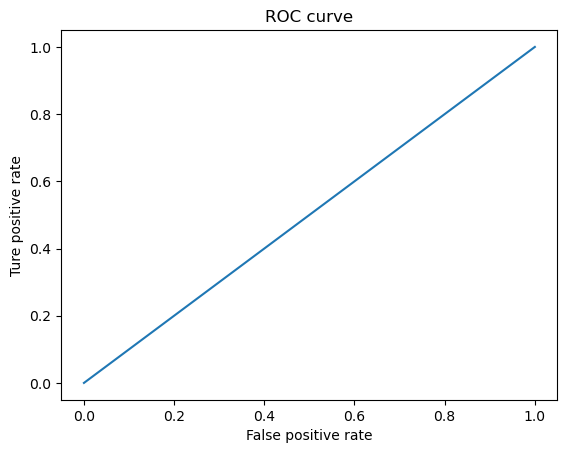

In [7]:
y_pred = model.predict(x_test)
test = model.evaluate(x_test, y_test)
fpr, tpr, threshold = skm.roc_curve(y_test, y_pred)

plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('Ture positive rate')

### Parameter optimization

Now I try to optimize some parameters of the network: the number of neurons, the dropout probability and the optimizer

In [8]:
%load_ext tensorboard

In [9]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([1, 5, 10, 15, 20]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.2, 0.5]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [10]:
def train_test_model(hparams):
    
  model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape = (x_train.shape[-1],)),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation = 'relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(1, activation = 'relu'),
  ])
    
  model.compile(
      optimizer = hparams[HP_OPTIMIZER],
      loss = keras.losses.BinaryCrossentropy(),
      metrics = ['accuracy'],
  )

  model.fit(x_train, y_train, epochs = 5) 
  _, accuracy = model.evaluate(x_val, y_val)
  return accuracy

In [11]:
def run(run_dir, hparams):
    
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step = 1)

In [12]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in HP_DROPOUT.domain.values:
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

--- Starting trial: run-0
{'num_units': 1, 'dropout': 0.1, 'optimizer': 'adam'}
Epoch 1/5


/Users/federicofantoccoli/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 300us/step - accuracy: 0.8128 - loss: 1.8833
Epoch 2/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - accuracy: 0.8542 - loss: 1.5657
Epoch 3/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - accuracy: 0.8719 - loss: 1.5338
Epoch 4/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - accuracy: 0.8743 - loss: 1.3602
Epoch 5/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - accuracy: 0.8748 - loss: 1.3833
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step - accuracy: 0.8889 - loss: 1.1888
--- Starting trial: run-1
{'num_units': 1, 'dropout': 0.1, 'optimizer': 'sgd'}
Epoch 1/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - accuracy: 0.8570 - loss: 2.3053
Epoch 2/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - accuracy: 0.8551 - loss: 2.3355
Epoch 3/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step - accuracy: 0.8580 - loss: 2.2884
Epoch 4/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - accuracy: 0.8567 - loss: 2.3100
Epoch 5/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - accuracy: 0.8594

In [13]:
%tensorboard --logdir logs/hparam_tuning

The best parameter set based on the accuracy is:

In [14]:
tuned_num_units = 15
tuned_dropout = 0.1
tuned_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Here other parameters thta I will try:
act_func = 'relu'
loss_function = keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy(name='binary accuracy'),
           #tf.keras.metrics.FBetaScore(beta = 1.0, name = 'f1_score', threshold=0.5),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.TrueNegatives(name = 'tn'),
           tf.keras.metrics.TruePositives(name = 'tp')
          ]
           

I can apply this optimized model on my problem of Quasars. First of all, I define my tuned model

In [17]:
def tuned_model (metrics, optimizer, units, t_dropout, loss_function, act_func):

    model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(shape = (x_train.shape[-1],), name = 'layers_flatten'),
    tf.keras.layers.Dense(units, activation = act_func , name = 'layers_dense'),
    tf.keras.layers.Dropout(t_dropout, name = 'layers_dropout'),
    tf.keras.layers.Dense(1, activation = act_func, name = 'layers_out')
    ])

    model.compile(optimizer = optimizer,
                  loss = loss_function,
                  metrics = metrics)

    return model

In [18]:
t_model = tuned_model(metrics, tuned_optimizer, tuned_num_units, tuned_dropout, loss_function, act_func)
t_model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layers_dense (Dense)            │ (None, 15)             │            75 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layers_dropout (Dropout)        │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layers_out (Dense)              │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91 (364.00 B)

 Trainable params: 91 (364.00 B)

 Non-trainable params: 0 (0.00 B)

Here I train the model using 20 epochs

In [19]:
training_res = t_model.fit(x_train, y_train, epochs = 20, validation_data = (x_val, y_val)) 

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - binary accuracy: 0.9218 - loss: 0.6673 - precision: 0.8458 - recall: 0.5094 - tn: 11900.2881 - tp: 1272.4155 - val_binary accuracy: 0.9819 - val_loss: 0.1348 - val_precision: 0.9382 - val_recall: 0.9274 - val_tn: 5992.0000 - val_tp: 881.0000
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - binary accuracy: 0.9768 - loss: 0.1629 - precision: 0.9388 - recall: 0.8944 - tn: 11916.9131 - tp: 1781.5776 - val_binary accuracy: 0.9816 - val_loss: 0.1383 - val_precision: 0.9438 - val_recall: 0.9189 - val_tn: 5998.0000 - val_tp: 873.0000
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - binary accuracy: 0.9761 - loss: 0.1581 - precision: 0.9299 - recall: 0.9007 - tn: 11880.3926 - tp: 1822.0879 - val_binary accuracy: 0.9819 - val_loss: 0.1329 - val_precision: 0.9439 - val_recall: 0.9211 - val_tn: 5998.0000 - val_tp: 875.0000
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - binary accuracy: 0.9803 - loss: 0.1359 - precision

Now I'll look at the results on the test set evaluatin my model

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - binary accuracy: 0.9850 - loss: 0.1200 - precision: 0.9633 - recall: 0.9300 - tn: 6428.2021 - tp: 995.7277
loss : 0.134
compile_metrics : 0.984
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


Galaxies classified as galaxies:  12765
QSO classified as galaxies:  83
Galaxies classified as QSO:  163
QSO classified as QSO:  1989 



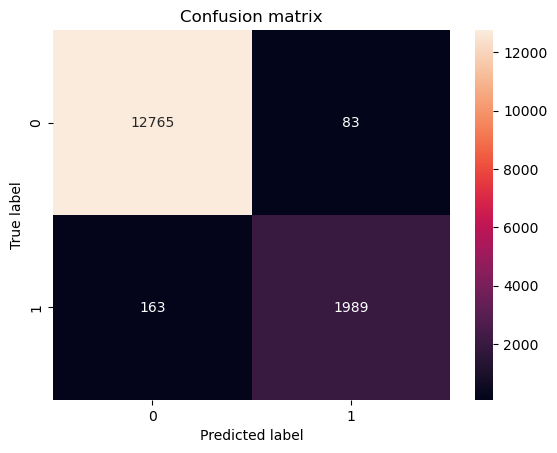

In [20]:
test_res = t_model.evaluate(x_test, y_test)

for name, value in zip(t_model.metrics_names, test_res):
  print(name, ': %.03f' %value)
conf_mat = skm.confusion_matrix(y_test, t_model.predict(x_test) > 0.5)

sns.heatmap(conf_mat, annot = True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

t_p, f_n, f_p, t_n = conf_mat.ravel()

print('\n')
print('Galaxies classified as galaxies: ', t_p)
print('QSO classified as galaxies: ', f_n)
print('Galaxies classified as QSO: ', f_p)
print('QSO classified as QSO: ', t_n, '\n')

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step


Text(0, 0.5, 'Ture positive rate')

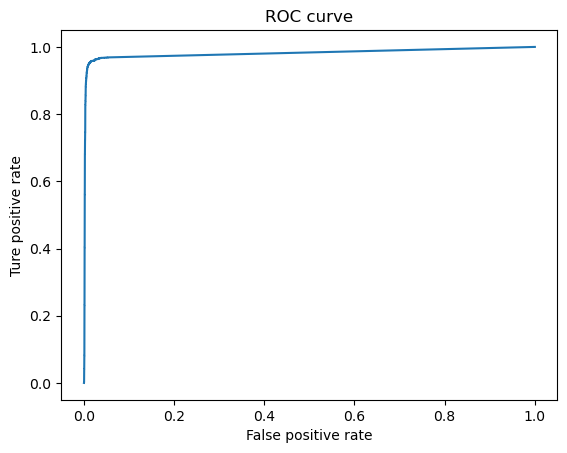

In [21]:
fpr, tpr, treshold = skm.roc_curve(y_test, t_model.predict(x_test))
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('Ture positive rate')

From the results of lecture 19, we see that is possible to obtain a good classification also without using a NN, for this problem it's not needed.